In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from math import sqrt
from scipy.stats import pearsonr, spearmanr

from env import get_connection
import wrangle_zillow
import prepare
import env
import acquire
import wrangle_mall


# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = acquire.get_zillow()

In [3]:
df.head()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [4]:
df = df.drop(columns = ['Unnamed: 0'])

In [5]:
df = df[df['bathroomcnt'] != 0]

In [6]:
df.shape

(76788, 68)

In [7]:
df = wrangle_zillow.handle_missing_values(df, 0.6, 0.6)

In [8]:
df.shape

(76788, 34)

# 1. How does Log error differ per county?

In [9]:
df.logerror[df.fips == 6037].count()

50384

In [10]:
df = df[df['taxvaluedollarcnt'] < 10000000]

In [11]:
ventura_county = df[df['fips'] == 6111]

In [12]:
orange_county = df[df['fips'] == 6059]

In [13]:
la_county = df[df['fips'] == 6037]

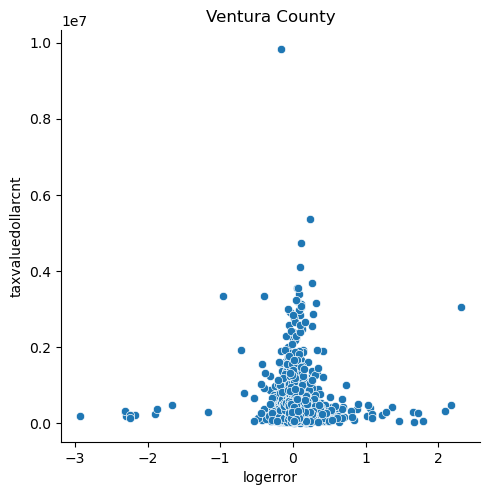

In [17]:
sns.relplot(data = ventura_county, x = 'logerror', y = 'taxvaluedollarcnt')
plt.title('Ventura County')
plt.show()

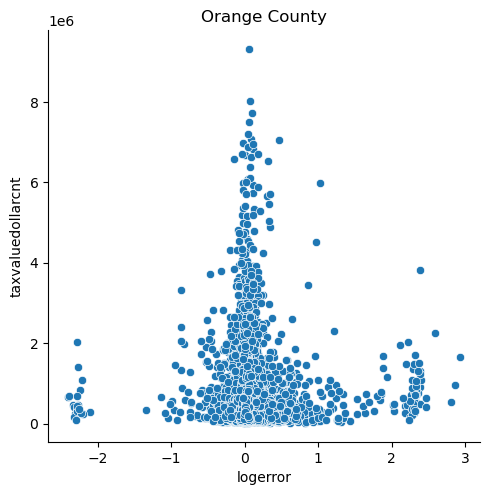

In [18]:
sns.relplot(data = orange_county, x = 'logerror', y = 'taxvaluedollarcnt')
plt.title('Orange County')
plt.show()

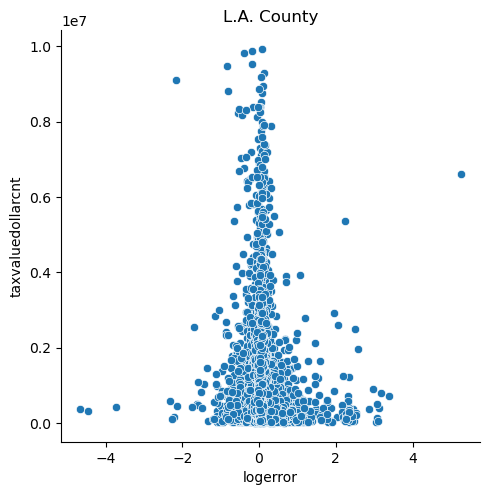

In [19]:
sns.relplot(data = la_county, x = 'logerror', y = 'taxvaluedollarcnt')
plt.title('L.A. County')
plt.show()

It seems there is a difference in the range of log errors with LA county being the largest, then orange county, and finally Ventura being the smallest


In [24]:
df.describe()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
count,7.675300e+04,7.675300e+04,76753.000000,76753.000000,49583.000000,76736.000000,76742.000000,73598.000000,76753.000000,76736.000000,...,76753.000000,50173.000000,76689.000000,7.667000e+04,7.675300e+04,76753.0,7.675300e+04,76748.000000,7.653300e+04,76753.000000
mean,1.495117e+06,1.299074e+07,2.314685,3.075202,6.535809,2.314696,1777.941167,1756.808650,6048.710995,2.248293,...,1.487603,1.093237,1968.689942,1.871670e+05,4.814916e+05,2016.0,2.945271e+05,5894.503016,6.049570e+13,0.016514
std,8.610721e+05,3.306759e+06,0.972384,1.110046,1.719770,0.972391,924.111339,915.094496,20.666997,0.958963,...,2.831734,0.421882,23.789678,2.048790e+05,5.411092e+05,0.0,3.918133e+05,6280.026017,1.541075e+12,0.168003
min,3.490000e+02,1.071186e+07,1.000000,0.000000,1.000000,1.000000,152.000000,152.000000,6037.000000,1.000000,...,0.000000,1.000000,1824.000000,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,6.037101e+13,-4.655420
25%,7.517210e+05,1.153404e+07,2.000000,2.000000,6.000000,2.000000,1181.000000,1172.000000,6037.000000,2.000000,...,0.000000,1.000000,1953.000000,8.438700e+04,2.070790e+05,2016.0,8.528100e+04,2716.422500,6.037311e+13,-0.024251
50%,1.497603e+06,1.252604e+07,2.000000,3.000000,6.000000,2.000000,1540.000000,1522.000000,6037.000000,2.000000,...,0.000000,1.000000,1970.000000,1.366275e+05,3.586800e+05,2016.0,2.030500e+05,4446.500000,6.037603e+13,0.006630
75%,2.241188e+06,1.420779e+07,3.000000,4.000000,8.000000,3.000000,2106.000000,2074.000000,6059.000000,3.000000,...,0.000000,1.000000,1987.000000,2.186512e+05,5.676800e+05,2016.0,3.651980e+05,6912.165000,6.059042e+13,0.039055
max,2.982274e+06,1.676885e+08,11.000000,16.000000,12.000000,11.000000,17245.000000,17245.000000,6111.000000,11.000000,...,15.000000,6.000000,2016.000000,7.238418e+06,9.935000e+06,2016.0,9.837579e+06,142488.690000,4.830301e+14,5.262999


# 2. Is taxamount and logerror related?

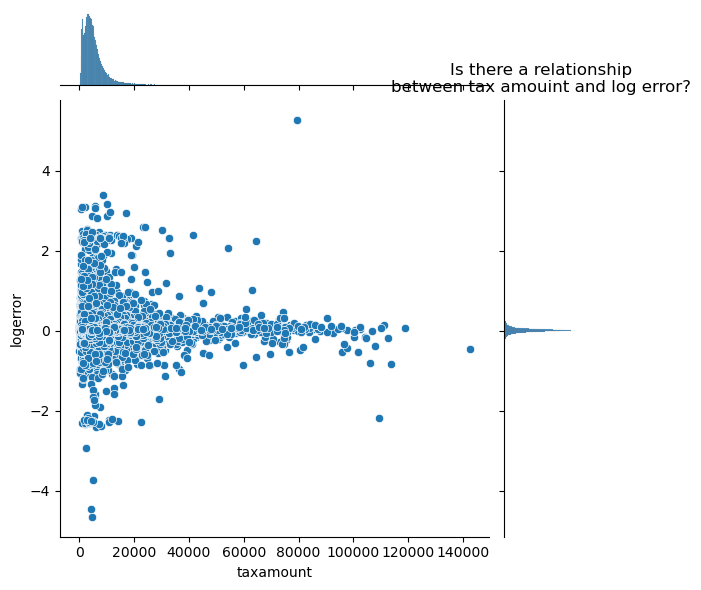

In [32]:
sns.jointplot(x="taxamount", y="logerror", data=df)
plt.xlabel("taxamount")
plt.ylabel("logerror")
plt.title("Is there a relationship\nbetween tax amouint and log error?")
plt.show()

There seems to be a bigger difference in logerror the less the taxamount is

# 3. Does yearbuilt have anything to do with logerror?

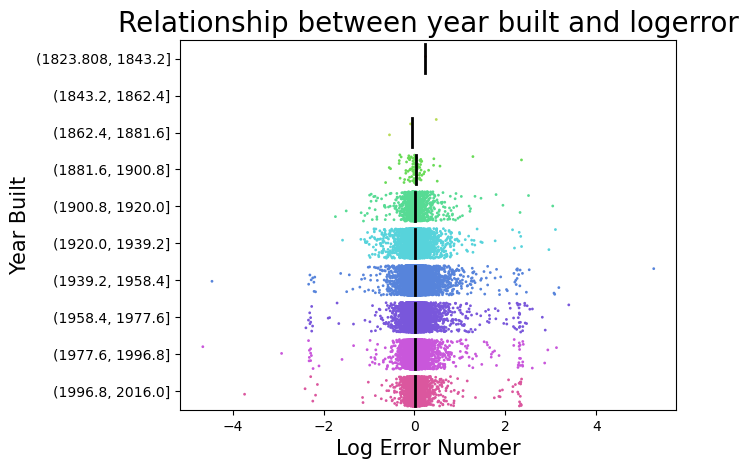

In [44]:
yearbuilt_bins = pd.cut(df.yearbuilt, 10)
p = sns.stripplot(y = yearbuilt_bins, x = df.logerror, data = df, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="logerror",
            y=yearbuilt_bins,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Year Built', fontdict = { 'fontsize': 15})
plt.xlabel('Log Error Number', fontdict = { 'fontsize': 15})
plt.title('Relationship between year built and logerror', fontdict = { 'fontsize': 20})

plt.show()

It seems like logerror disparity started to significantly increase after 1939

# 4. Square footage and logerror

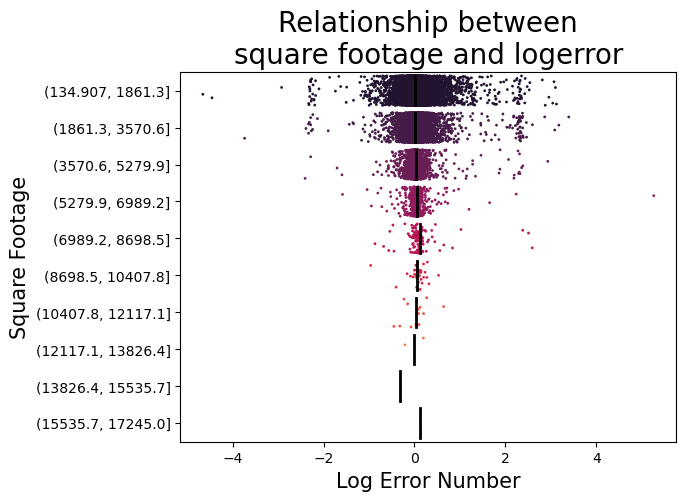

In [49]:
sqft_bins = pd.cut(df.calculatedfinishedsquarefeet, 10)
p = sns.stripplot(y = sqft_bins, x = df.logerror, data = df, size = 2, jitter = .4, palette = 'rocket')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x='logerror',
            y=sqft_bins,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Square Footage', fontdict = { 'fontsize': 15})
plt.xlabel('Log Error Number', fontdict = { 'fontsize': 15})
plt.title('Relationship between\nsquare footage and logerror', fontdict = { 'fontsize': 20})

plt.show()

It seems the lower the square footage, the bigger distribution of logerror

# 5. Does total room count have any relation to logerror

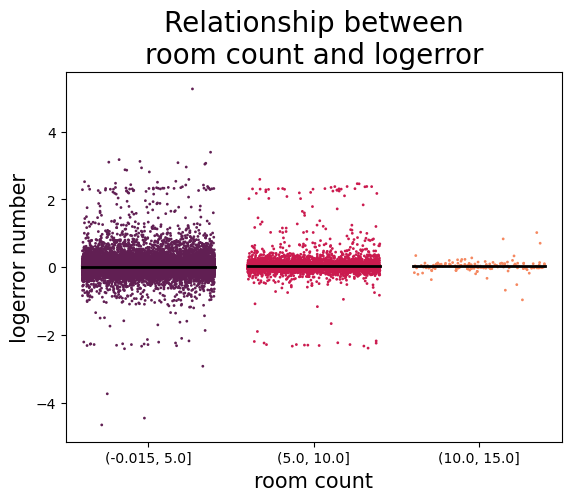

In [52]:
roomcnt_bins = pd.cut(df.roomcnt, 3)
p = sns.stripplot(x = roomcnt_bins, y = df.logerror, data = df, size = 2, jitter = .4, palette = 'rocket')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=roomcnt_bins,
            y='logerror',
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('logerror number', fontdict = { 'fontsize': 15})
plt.xlabel('room count', fontdict = { 'fontsize': 15})
plt.title('Relationship between\nroom count and logerror', fontdict = { 'fontsize': 20})

plt.show()

The findings altogether tell me that the smaller the house the wider spread the logerror is